### Pre-process step 2
- Get transformation from camera pixel to wavelength in nm
- Needs:
    - wavelengthCalibrationImage.tif from pre-process set 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from PIL import Image
from scipy.signal import find_peaks
import pandas as pd
import h5py

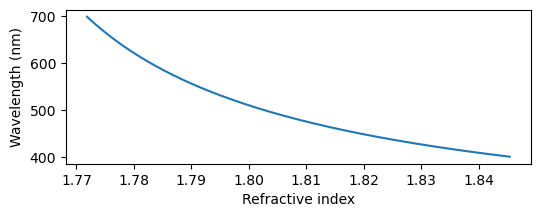

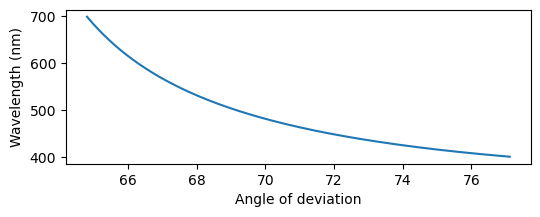

In [2]:
# Refractive index of N-SF11
wavelength = np.arange(0.4,0.7,0.001)

# Sellmeier equation for N-SF11
n = np.sqrt(1 + ((1.73759695*wavelength**2)/((wavelength**2)-0.013188707)) + ((0.313747356*wavelength**2)/((wavelength**2)-0.0623068142)) + ((1.89878101*wavelength**2)/((wavelength**2)-155.23629)))
f, ax = plt.subplots(figsize=(6,2))
ax.plot(n, 1000*wavelength)
ax.set(ylabel='Wavelength (nm)', xlabel='Refractive index')
plt.show()

# Angle of deviation
theta_I = 60.8
alpha = 60
theta_D = theta_I - alpha + np.rad2deg(np.arcsin((np.sin(np.deg2rad(alpha))*np.sqrt(n**2 - np.sin(np.deg2rad(theta_I))**2)) - (np.sin(np.deg2rad(theta_I))*np.cos(np.deg2rad(alpha)))))
f, ax = plt.subplots(figsize=(6,2))
ax.plot(theta_D, 1000*wavelength)
ax.set(ylabel='Wavelength (nm)', xlabel='Angle of deviation')
plt.show()

Paths are for dataset tagged: all


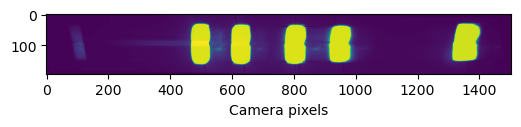

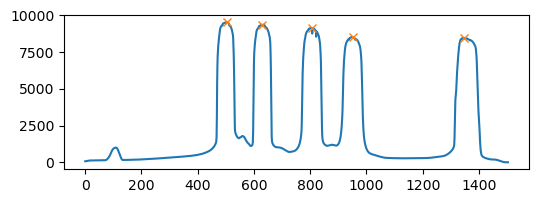

array([ 503,  629,  805,  951, 1346], dtype=int64)

In [3]:
# Calibration image with 5 lasers turned on
from config import load_config
paths = load_config(dataset_key='all')
I = Image.open(paths['raw_data'] / 'CalibrationImage.tiff')

im = np.array(I)
f,ax = plt.subplots(figsize=(6,6))
ax.imshow(im)
ax.set(xlabel='Camera pixels')
ax.grid(False)

# Extract center position of laser from image
im_line = np.mean(im,axis=0)
laser_pix, _ = find_peaks(im_line, height=4000, distance=100)
f, ax = plt.subplots(figsize=(6,2))
ax.plot(im_line)
ax.plot(laser_pix, im_line[laser_pix], 'x')
plt.show()
laser_pix

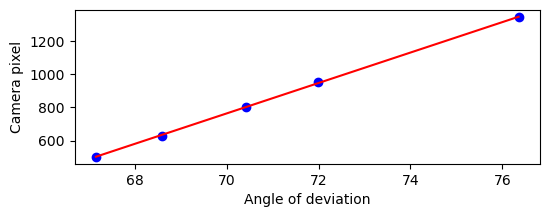

array([   91.92407822, -5670.45267987])

In [4]:
# Optimization function to return pixel value given angle of deviation as input
# f_lambda_r: pixel position of wavelength that makes a right angle with the camera sensor
# r: distance from convergence point to camera sensor
# theta_D_r: angle of deviation of the right angled wavelength
# def wave(xdata, f_lambda_r, r, theta_D_r): 
    #return np.tan(np.deg2rad(theta_D_r - xdata))*r + f_lambda_r

# Changed fit to a linear fit
def wave(xdata, a, b): 
    return a*xdata + b

lasers = np.array([0.561, 0.514, 0.473, 0.448, 0.405]) # Lasers use for calibration
theta_I = 60.8 # Angle of incidence
alpha = 60 # Apex angle of prism
n = np.sqrt(1 + ((1.73759695*lasers**2)/((lasers**2)-0.013188707)) + ((0.313747356*lasers**2)/((lasers**2)-0.0623068142)) + ((1.89878101*lasers**2)/((lasers**2)-155.23629)))
xdata = theta_I - alpha + np.rad2deg(np.arcsin((np.sin(np.deg2rad(alpha))*np.sqrt(n**2 - np.sin(np.deg2rad(theta_I))**2)) - (np.sin(np.deg2rad(theta_I))*np.cos(np.deg2rad(alpha)))))
ydata = laser_pix
# popt, pcov = curve_fit(wave, xdata, ydata, bounds=([1, -np.inf, 60],[2048, np.inf, 80]))
popt, pcov = curve_fit(wave, xdata, ydata)

f, ax = plt.subplots(figsize=(6,2))
ax.plot(xdata, ydata, 'bo')
ax.plot(xdata, wave(xdata, *popt), 'r-')
ax.set(ylabel='Camera pixel', xlabel='Angle of deviation')
plt.show()
popt

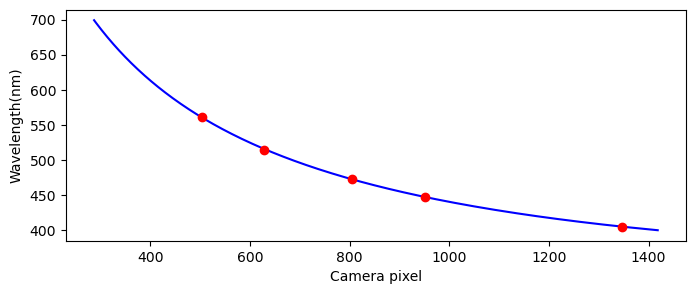

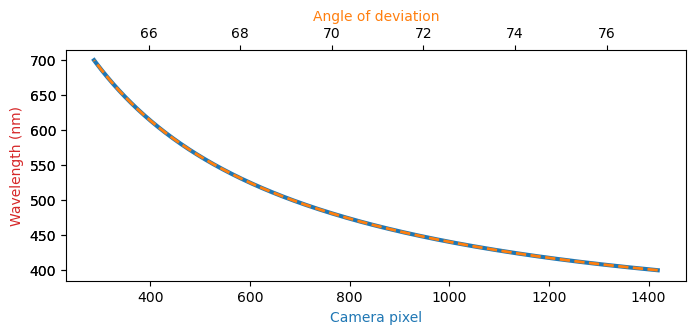

     Camera_pixel  Wavelength_nm
0            1758            400
1            1744            401
2            1730            402
3            1715            403
4            1702            404
..            ...            ...
295           631            695
296           630            696
297           629            697
298           628            698
299           627            699

[300 rows x 2 columns]
967
516


In [5]:
# From optimization curve, extract pixel position for all wavelengths
wavelength = np.arange(0.4,0.7,0.001)
n = np.sqrt(1 + ((1.73759695*wavelength**2)/((wavelength**2)-0.013188707)) + ((0.313747356*wavelength**2)/((wavelength**2)-0.0623068142)) + ((1.89878101*wavelength**2)/((wavelength**2)-155.23629)))
theta_I = 60.8
alpha = 60
theta_D = theta_I - alpha + np.rad2deg(np.arcsin((np.sin(np.deg2rad(alpha))*np.sqrt(n**2 - np.sin(np.deg2rad(theta_I))**2)) - (np.sin(np.deg2rad(theta_I))*np.cos(np.deg2rad(alpha)))))
#pixel_value = wave(theta_D, popt[0],popt[1],popt[2])
pixel_value = wave(theta_D, popt[0],popt[1])

f, ax = plt.subplots(figsize=(8,3))
ax.plot(pixel_value, 1000*wavelength, 'b-')
ax.plot(laser_pix, 1000*lasers, 'ro')
ax.set(xlabel='Camera pixel', ylabel='Wavelength(nm)')
plt.show()

fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(111, label='1')
ax1.plot(pixel_value, 1000*wavelength, color='C0', linewidth=3)
ax1.set_xlabel('Camera pixel', color='C0')
ax1.set_ylabel('Wavelength (nm)', color='C3')
ax2 = fig.add_subplot(111, label='2', frame_on=False)
ax2.plot(theta_D, 1000*wavelength, '--', color='C1', linewidth=2)
ax2.xaxis.tick_top()
ax2.set_xlabel('Angle of deviation', color='C1')
ax2.xaxis.set_label_position('top') 
plt.show()

# Read from calibration.txt
with open(paths['raw_data'] / 'calibration.txt', 'r') as f:
    for line in f:
        name, value = line.strip().split(' = ')
        exec(f'{name} = {value}')

pixel_value_new = calib_Xoffset + np.round(pixel_value).astype(int)
LUT = {'Camera_pixel':pixel_value_new, 'Wavelength_nm': (1000*wavelength).astype(int)}
lut = pd.DataFrame(data=LUT)
print(lut)
idx = 116
print(lut.Camera_pixel[idx])
print(lut.Wavelength_nm[idx])

In [6]:
# write h5 file with pandas dataframe
import tables as tb
store = pd.HDFStore(paths['raw_data']/'pixel_to_nm.hdf5')
for key in lut.keys():
    lut[key].to_hdf(store, key=key, mode='a')
store.close()

with h5py.File(paths['raw_data']/'pixel_to_nm.hdf5', 'r') as f:
    print(f.keys())
    

<KeysViewHDF5 ['Camera_pixel', 'Wavelength_nm']>
